In [1]:
#won't be running this too due to potato pc problems

In [2]:
import tensorflow as tf
import os
import random
import numpy as np

In [3]:
seed_num = 12020
random.seed(seed_num)
np.random.seed(seed_num)
tf.random.set_seed(seed_num)

In [4]:
from tensorflow.keras.datasets import fashion_mnist

(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

assert x_train.shape == (60000, 28, 28)
assert x_test.shape == (10000, 28, 28)
assert y_train.shape == (60000,)
assert y_test.shape == (10000,)

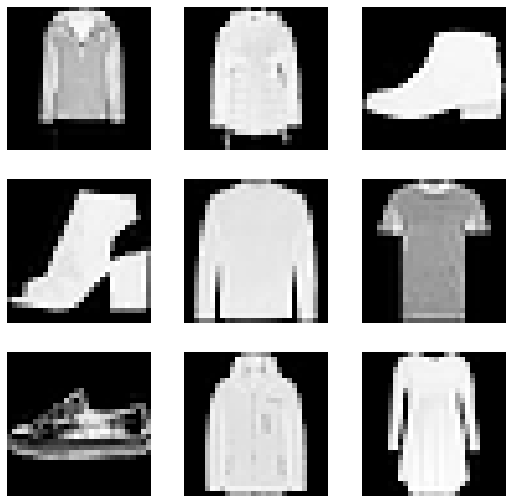

In [5]:
import numpy as np 

from matplotlib import pyplot as plt 

plt.figure(figsize=(9,9))

rand_samples = np.random.choice(60000, 9)

for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(x_train[rand_samples[i]], cmap="Greys_r")
    plt.axis('off')

plt.show()    

In [6]:
dataset = np.concatenate([x_train, x_test], axis = 0 )

dataset = np.expand_dims(dataset, -1).astype("float32") / 255

In [7]:
from tensorflow import keras
from tensorflow.keras import layers 


class SamplingLayer(layers.Layer):

    def call(self, inputs):
        zMean, zLogVar = inputs
        batch = tf.shape(zMean)[0]
        dim = tf.shape(zMean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return zMean + tf.exp(0.5 * zLogVar) * epsilon

In [9]:
#building encoder

def buildEncoder(latentDim, encoderInputs):
    l1 = keras.models.Sequential([
    layers.Conv2D(128, 3, activation="relu", strides=2, padding="same"),
    layers.Conv2D(64, 3, activation="relu", strides=2, padding="same"),
    layers.Flatten(),
    layers.Dense(256, activation="relu")
    ])
    x = l1(encoderInputs)
    zMean = layers.Dense(latentDim, name="z_mean")(x)
    zLogVar = layers.Dense(latentDim, name="z_log_var")(x)
    z = SamplingLayer()([zMean, zLogVar])
    return keras.Model(encoderInputs, [zMean, zLogVar, z], name="encoder")


encoderInputs = keras.Input(shape=(28, 28, 1))
encoder = buildEncoder(2, encoderInputs)
encoder.summary()


Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 sequential (Sequential)        (None, 256)          878144      ['input_1[0][0]']                
                                                                                                  
 z_mean (Dense)                 (None, 2)            514         ['sequential[0][0]']             
                                                                                                  
 z_log_var (Dense)              (None, 2)            514         ['sequential[0][0]']             
                                                                                            

In [10]:
def buildDecoder(latentInputs):
  l1 = keras.models.Sequential([
    layers.Dense(7*7*64, activation="relu", input_shape=(latentInputs.shape[1],)),
    layers.Reshape((7,7,64)),
    layers.Conv2DTranspose(128, 3, activation="relu", strides=2, padding="same"),
    layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same"),
    layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")
  ])

  return keras.Model(latentInputs, l1(latentInputs), name = "decoder")


latentInputs = keras.Input(shape=(2,))
decoder = buildDecoder(latentInputs)
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 2)]               0         
                                                                 
 sequential_1 (Sequential)   (None, 28, 28, 1)         157633    
                                                                 
Total params: 157,633
Trainable params: 157,633
Non-trainable params: 0
_________________________________________________________________


In [11]:
def reconstructionLoss(data, reconstructed):
  return tf.reduce_mean(
      tf.reduce_sum(
          keras.losses.binary_crossentropy(data, reconstructed),
          axis=(1, 2)
      )
  )

In [12]:
def klDivergenceLoss(zMean, zLogVar):
  return tf.reduce_mean(
      tf.reduce_sum(
          -0.5 * (1 + zLogVar - tf.square(zMean) - tf.exp(zLogVar)),
          axis=1
      )
  )